In [1]:
# Install required packages
!pip install -q tensorflow numpy pandas matplotlib seaborn scikit-learn joblib plotly h5py ipywidgets tqdm


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# EnrollPredict.ai: Enrollment Prediction Model

This notebook builds a TensorFlow LSTM model that predicts student enrollment numbers (`Actual_Enrollment`) based on various features including application trends, program metrics, and sentiment indicators.

## Overview

1. Data Loading and Exploration
2. Data Analysis and Visualization
3. Data Preprocessing
4. Time Series Model Building
5. Model Training
6. Model Evaluation
7. Model Saving

## 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Reinstall TensorFlow with compatible version
#%pip install tensorflow --force-reinstall

# Import TensorFlow after installation
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import os

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Display versions
print(f"TensorFlow version: {tf.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

ImportError: Traceback (most recent call last):
  File "c:\Users\ngand\Desktop\EnrollPredict.ai\.venv\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

## 2. Load and Explore the Dataset

In [2]:
# Load the enrollment data from JSON file
with open('dataset.json', 'r') as f:
    data = json.load(f)

# Convert to pandas DataFrame
df = pd.DataFrame(data['enrollment_data'])

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nPrograms: {df['Program'].unique()}")
print(f"\nYears range: {df['Year'].min()} to {df['Year'].max()}")

Dataset shape: (50, 22)

Columns: ['Year', 'Quarter', 'Program', 'Previous_Year_Enrollment', 'Applications_Received', 'Acceptance_Rate', 'Conversion_Rate', 'Actual_Enrollment', 'Mining_Industry_Growth', 'Secondary_School_Graduates', 'Marketing_Budget_Allocation', 'Scholarship_Funds_Available', 'Competitor_New_Programs', 'Average_Entry_Test_Score', 'Female_Applicant_Percentage', 'Urban_Applicant_Percentage', 'International_Applicant_Percentage', 'Faculty_Student_Ratio', 'Program_Ranking', 'Program_Trend_Sentiment', 'Economic_Factor_Sentiment', 'General_Interest_Sentiment']

Programs: ['Mining Engineering' 'Computer Science' 'Business Administration'
 'Electrical Engineering' 'Environmental Science']

Years range: 2020 to 2024


In [3]:
# Display first few rows
df.head()

,Year,Quarter,Program,Previous_Year_Enrollment,Applications_Received,Acceptance_Rate,Conversion_Rate,Actual_Enrollment,Mining_Industry_Growth,Secondary_School_Graduates,...,Competitor_New_Programs,Average_Entry_Test_Score,Female_Applicant_Percentage,Urban_Applicant_Percentage,International_Applicant_Percentage,Faculty_Student_Ratio,Program_Ranking,Program_Trend_Sentiment,Economic_Factor_Sentiment,General_Interest_Sentiment
0,2020,1,Mining Engineering,245000,420000,0.72,0.82,248000,0.03,3450,...,0,68.5,24,65,12,0.07,3,0.75,0.68,0.72
1,2020,1,Computer Science,180000,310000,0.65,0.78,158000,0.01,3450,...,1,72.1,32,78,15,0.06,4,0.85,0.72,0.81
2,2020,1,Business Administration,210000,380000,0.75,0.68,195000,0.01,3450,...,2,65.7,48,70,8,0.08,5,0.70,0.65,0.68
3,2020,1,Electrical Engineering,190000,290000,0.70,0.80,162000,0.02,3450,...,0,70.2,28,68,10,0.07,4,0.72,0.70,0.74
4,2020,1,Environmental Science,120000,200000,0.80,0.65,104000,0.02,3450,...,1,64.8,52,62,7,0.05,6,0.60,0.55,0.58


In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0] if any(missing_values > 0) else "No missing values")

Missing values per column:
No missing values


In [5]:
# Summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,50.0,2022.0000,1.428571,2020.00,2021.0000,2022.000,2023.0000,2024.00
Quarter,50.0,1.5000,0.505076,1.00,1.0000,1.500,2.0000,2.00
Previous_Year_Enrollment,50.0,203000.0000,47039.714007,103000.00,168250.0000,210000.000,236500.0000,293000.00
Applications_Received,50.0,377100.0000,82530.699297,200000.00,313750.0000,387500.000,430000.0000,535000.00
Acceptance_Rate,50.0,0.7004,0.069868,0.50,0.6800,0.710,0.7400,0.81
Conversion_Rate,50.0,0.7934,0.073307,0.63,0.7425,0.815,0.8500,0.90
Actual_Enrollment,50.0,208440.0000,47794.270001,103000.00,173750.0000,215500.000,239750.0000,300000.00
Mining_Industry_Growth,50.0,0.0438,0.023980,0.00,0.0225,0.040,0.0600,0.11
Secondary_School_Graduates,50.0,3452.0000,130.211758,3200.00,3380.0000,3460.000,3550.0000,3650.00
Marketing_Budget_Allocation,50.0,77300.0000,15369.264319,40000.00,68500.0000,79000.000,88000.0000,105000.00


## 3. Data Analysis and Visualization

Let's analyze our data to identify patterns and relationships between variables.

### 3.1. Enrollment Trends Over Time

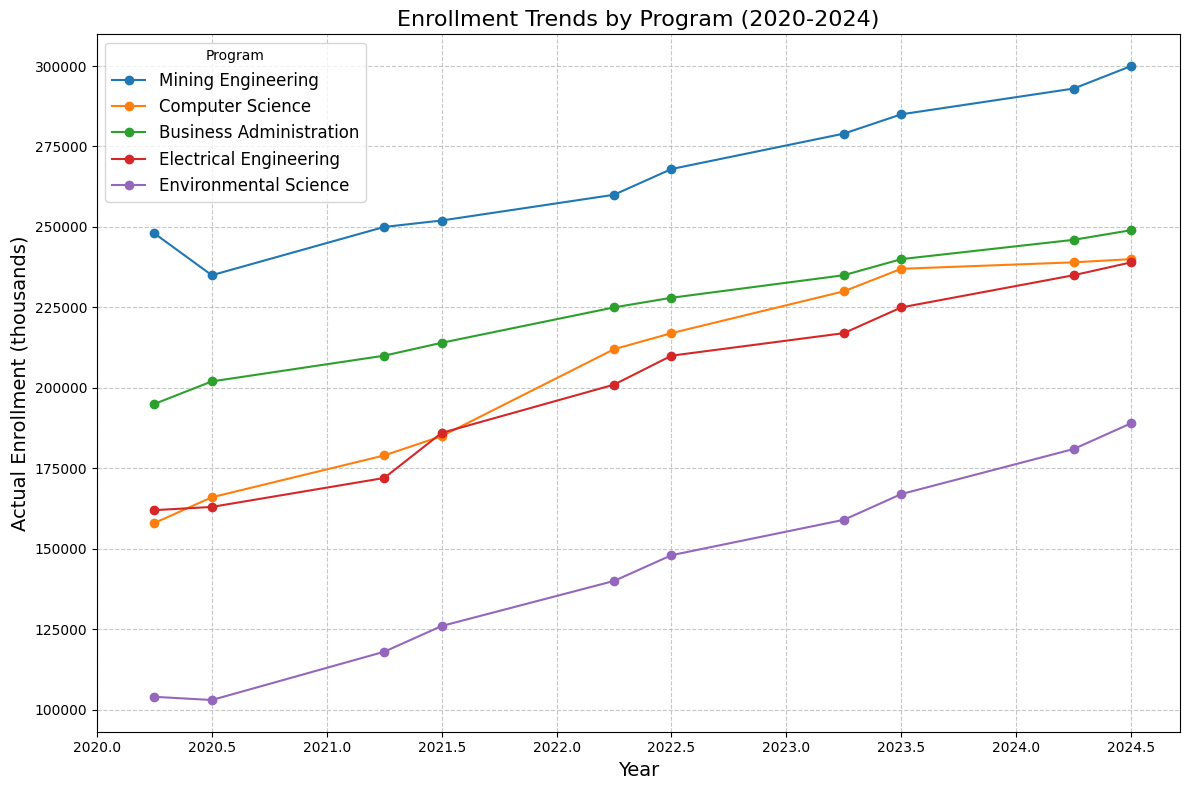

In [6]:
plt.figure(figsize=(12, 8))
for program in df['Program'].unique():
    program_data = df[df['Program'] == program]
    plt.plot(program_data['Year'] + program_data['Quarter']/4, program_data['Actual_Enrollment'], marker='o', linestyle='-', label=program)

plt.title('Enrollment Trends by Program (2020-2024)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Actual Enrollment (thousands)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Program', fontsize=12)
plt.xticks(np.arange(2020, 2025, 0.5))
plt.tight_layout()
plt.show()

### 3.2. Applications vs. Actual Enrollment

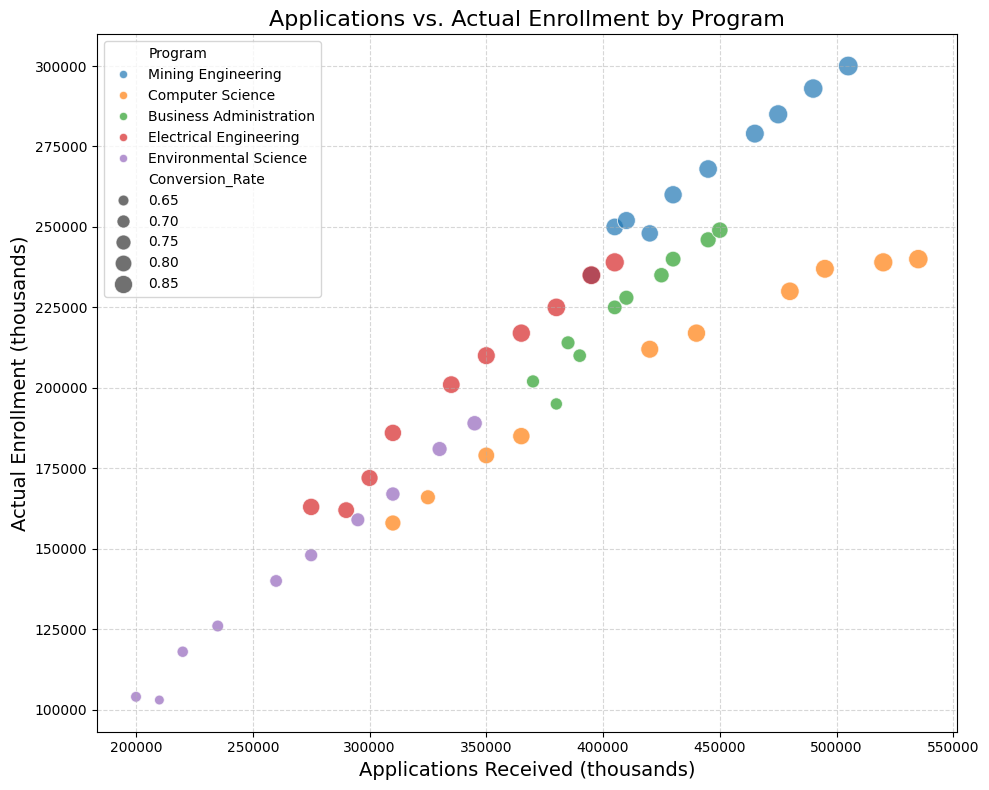

In [7]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='Applications_Received', y='Actual_Enrollment', hue='Program', size='Conversion_Rate',
                sizes=(50, 200), alpha=0.7)
plt.title('Applications vs. Actual Enrollment by Program', fontsize=16)
plt.xlabel('Applications Received (thousands)', fontsize=14)
plt.ylabel('Actual Enrollment (thousands)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

### 3.3. Correlation Analysis

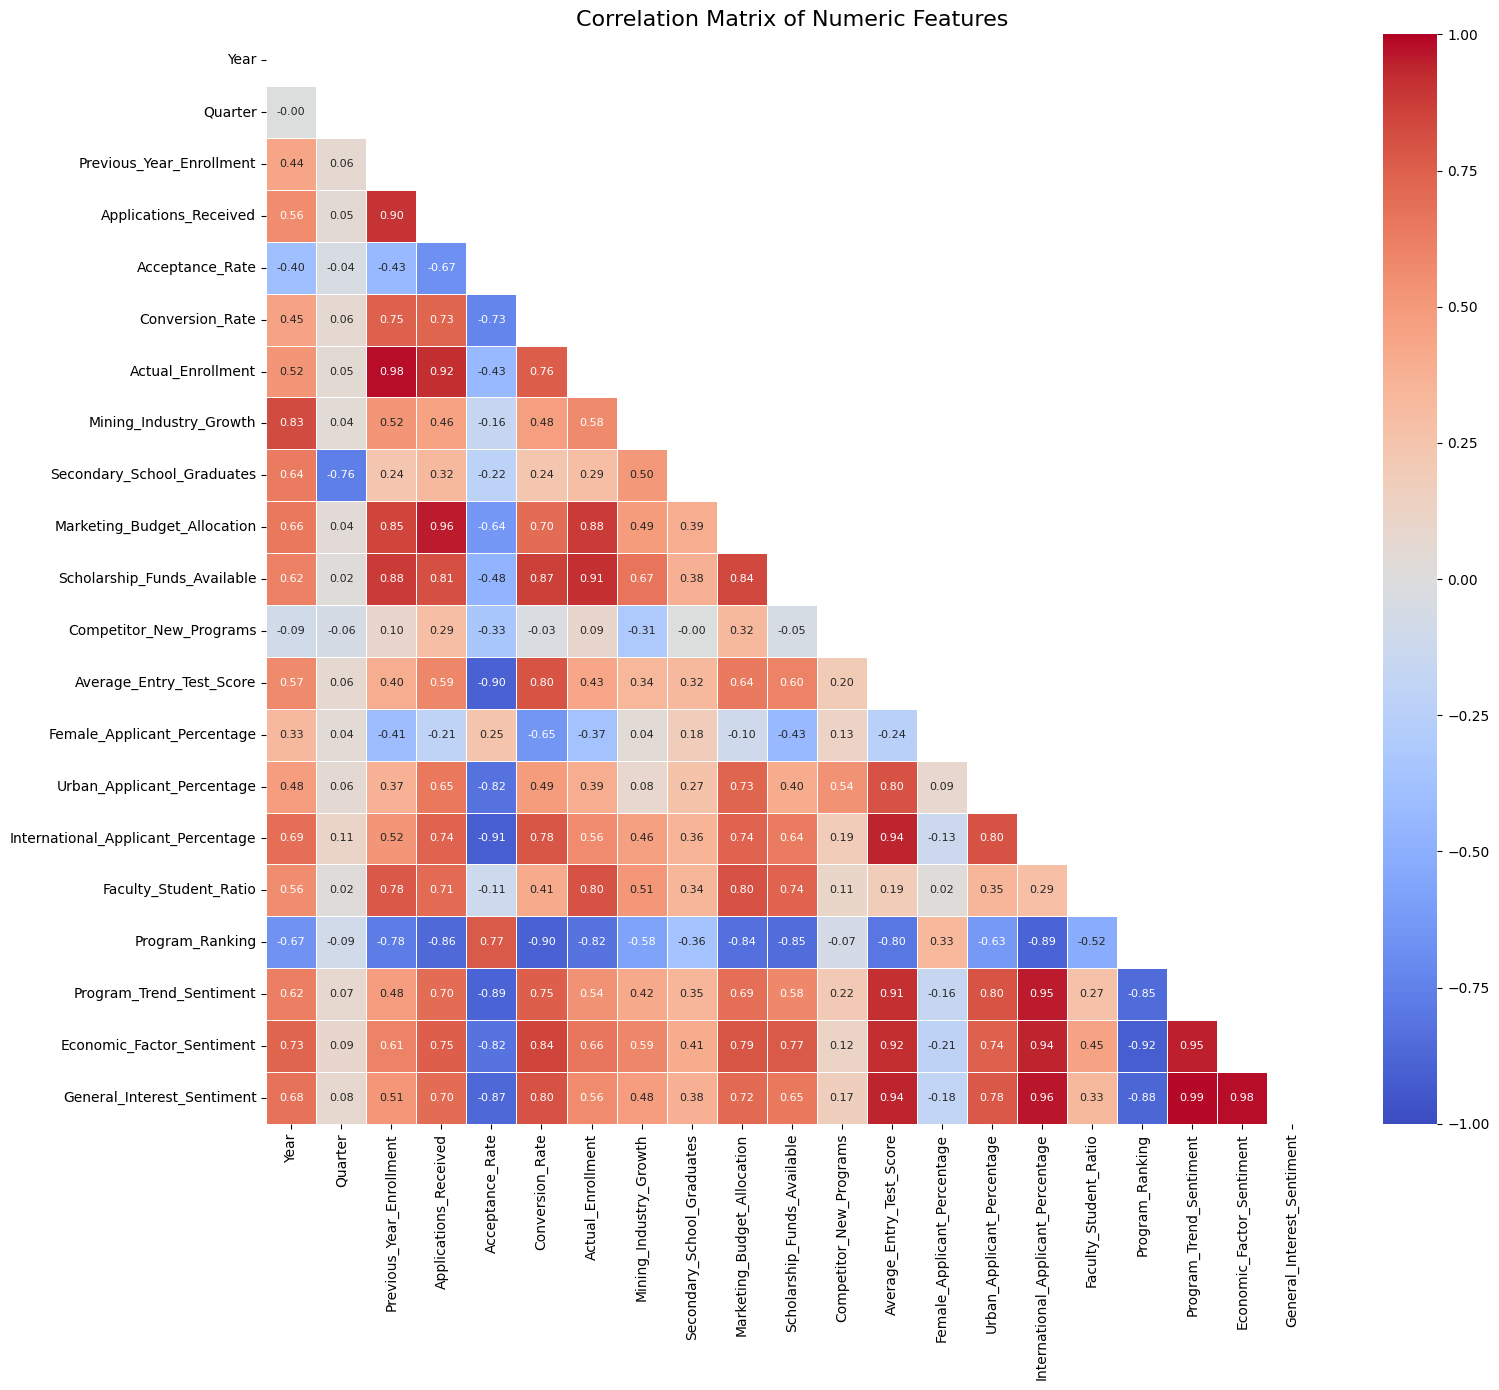

In [8]:
# Calculate correlation matrix
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(correlation_matrix)
heatmap = sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', 
                      linewidths=0.5, annot_kws={'size': 8}, fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
# Identify top correlations with Actual_Enrollment
enrollment_corr = correlation_matrix['Actual_Enrollment'].sort_values(ascending=False)
print("Top correlations with Actual_Enrollment:")
print(enrollment_corr)

Top correlations with Actual_Enrollment:
Actual_Enrollment                     1.000000
Previous_Year_Enrollment              0.979674
Applications_Received                 0.920652
Scholarship_Funds_Available           0.908513
Marketing_Budget_Allocation           0.878335
Faculty_Student_Ratio                 0.798149
Conversion_Rate                       0.762033
Economic_Factor_Sentiment             0.662727
Mining_Industry_Growth                0.577213
International_Applicant_Percentage    0.564435
General_Interest_Sentiment            0.564041
Program_Trend_Sentiment               0.538725
Year                                  0.517695
Average_Entry_Test_Score              0.434658
Urban_Applicant_Percentage            0.392473
Secondary_School_Graduates            0.292695
Competitor_New_Programs               0.093566
Quarter                               0.053261
Female_Applicant_Percentage          -0.374294
Acceptance_Rate                      -0.432386
Program_Ranking    

### 3.4. Impact of Sentiment Indicators

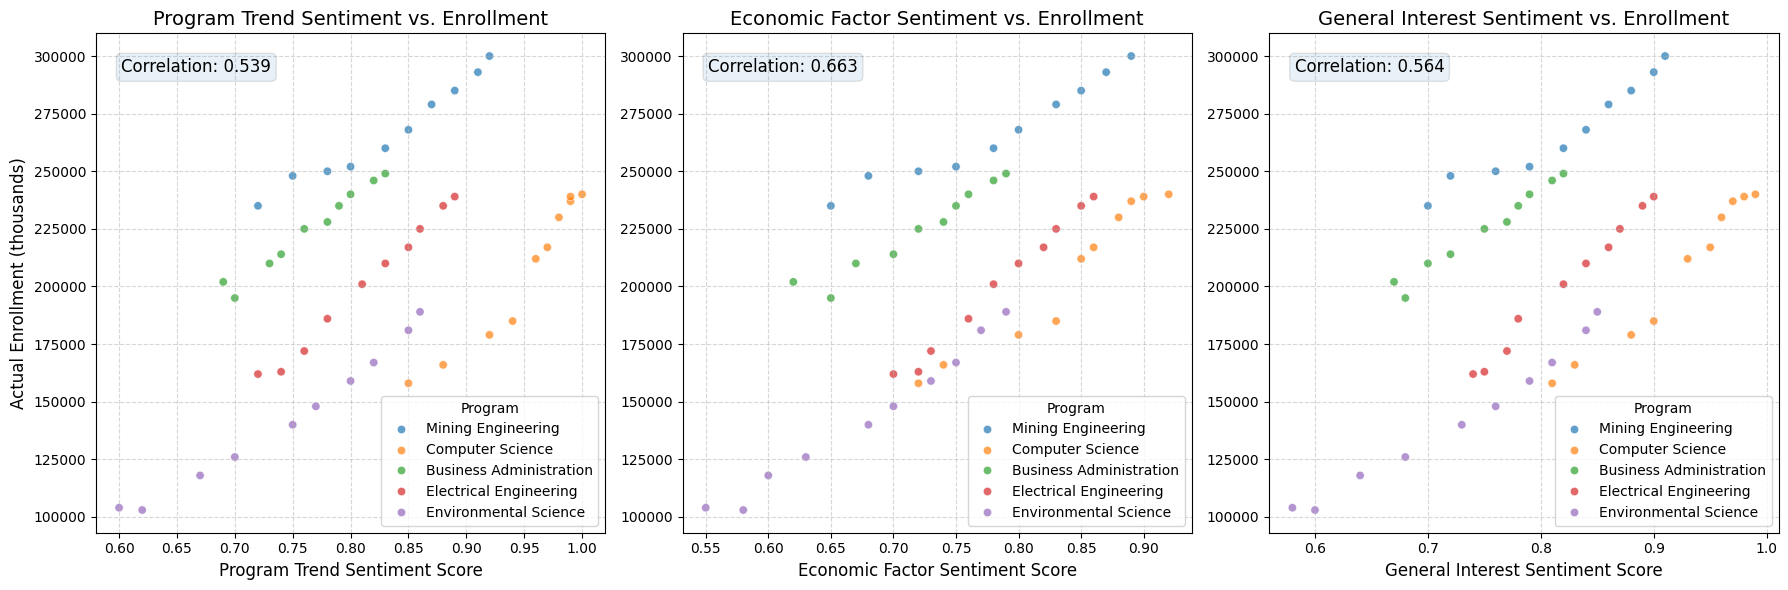

In [10]:
# Setup a 3x1 subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot relationship between each sentiment and actual enrollment
sentiments = ['Program_Trend_Sentiment', 'Economic_Factor_Sentiment', 'General_Interest_Sentiment']
titles = ['Program Trend', 'Economic Factor', 'General Interest']

for i, (sentiment, title) in enumerate(zip(sentiments, titles)):
    sns.scatterplot(data=df, x=sentiment, y='Actual_Enrollment', hue='Program', ax=axes[i], alpha=0.7)
    axes[i].set_title(f'{title} Sentiment vs. Enrollment', fontsize=14)
    axes[i].set_xlabel(f'{title} Sentiment Score', fontsize=12)
    if i == 0:
        axes[i].set_ylabel('Actual Enrollment (thousands)', fontsize=12)
    else:
        axes[i].set_ylabel('')
    axes[i].grid(True, linestyle='--', alpha=0.5)
    
    # Calculate and display the correlation coefficient
    corr = df[[sentiment, 'Actual_Enrollment']].corr().iloc[0,1]
    axes[i].text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=axes[i].transAxes, 
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

plt.tight_layout()
plt.show()

### 3.5. Program Rankings Impact on Enrollment

C:\Users\ngand\AppData\Local\Temp\ipykernel_5268\3786346232.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Program_Ranking', y='Actual_Enrollment', palette='viridis')


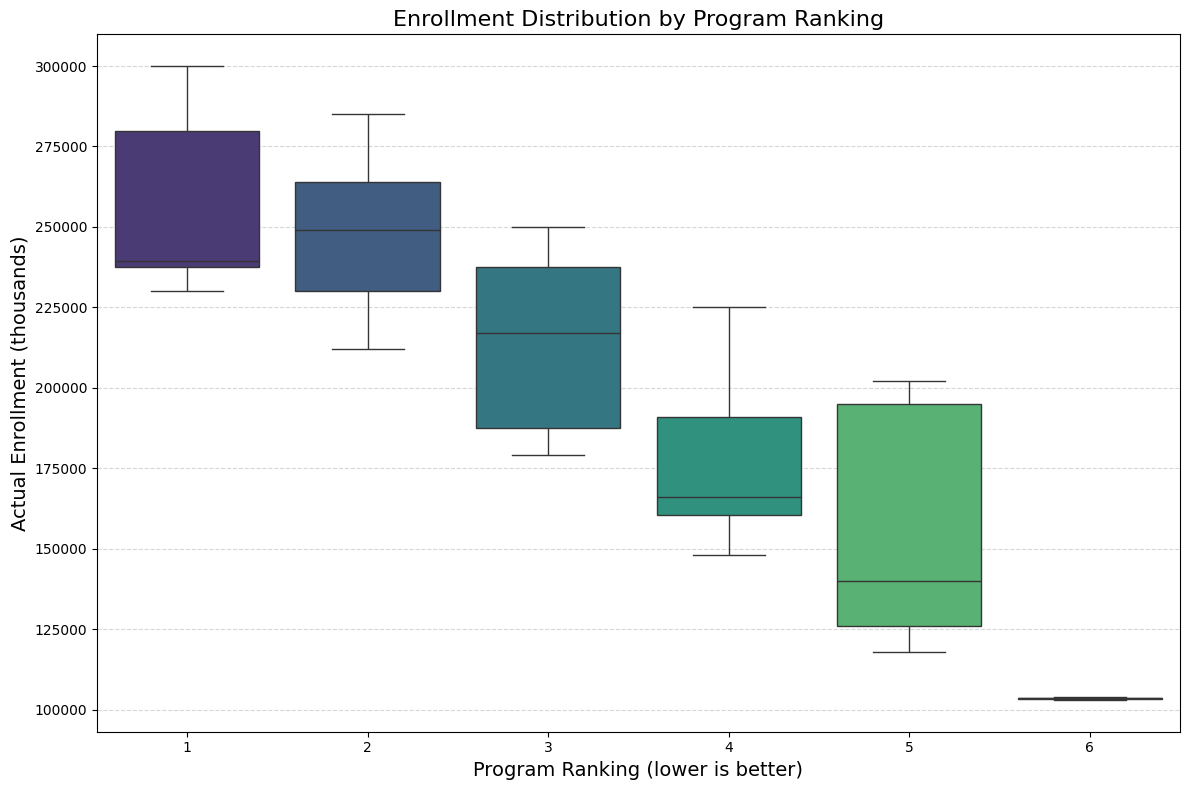

In [11]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='Program_Ranking', y='Actual_Enrollment', palette='viridis')
plt.title('Enrollment Distribution by Program Ranking', fontsize=16)
plt.xlabel('Program Ranking (lower is better)', fontsize=14)
plt.ylabel('Actual Enrollment (thousands)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5, axis='y')
plt.tight_layout()
plt.show()

### 3.6. Year-over-Year Enrollment Growth

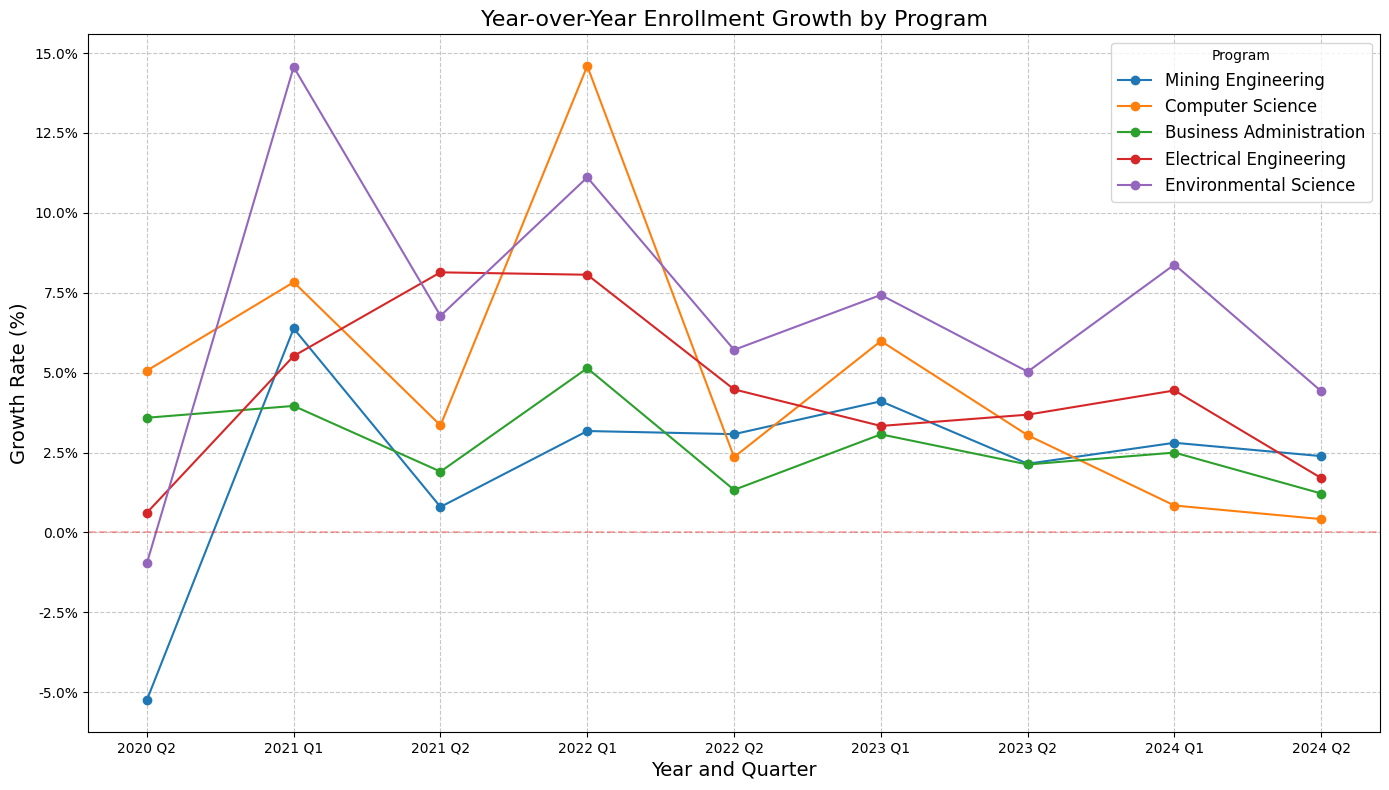

In [13]:
# Calculate year-over-year growth
df_pivot = df.pivot_table(index=['Year', 'Quarter'], columns='Program', values='Actual_Enrollment')
df_growth = df_pivot.pct_change().dropna()

# Convert MultiIndex to a single-level index for plotting
df_growth.index = df_growth.index.map(lambda x: f"{x[0]} Q{x[1]}")

# Plot year-over-year growth
plt.figure(figsize=(14, 8))
for program in df['Program'].unique():
    plt.plot(df_growth.index, df_growth[program], marker='o', linestyle='-', label=program)

plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.title('Year-over-Year Enrollment Growth by Program', fontsize=16)
plt.xlabel('Year and Quarter', fontsize=14)
plt.ylabel('Growth Rate (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Program', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
plt.tight_layout()
plt.show()

### 3.7. Applicant Demographics Analysis

C:\Users\ngand\AppData\Local\Temp\ipykernel_5268\2477171986.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')


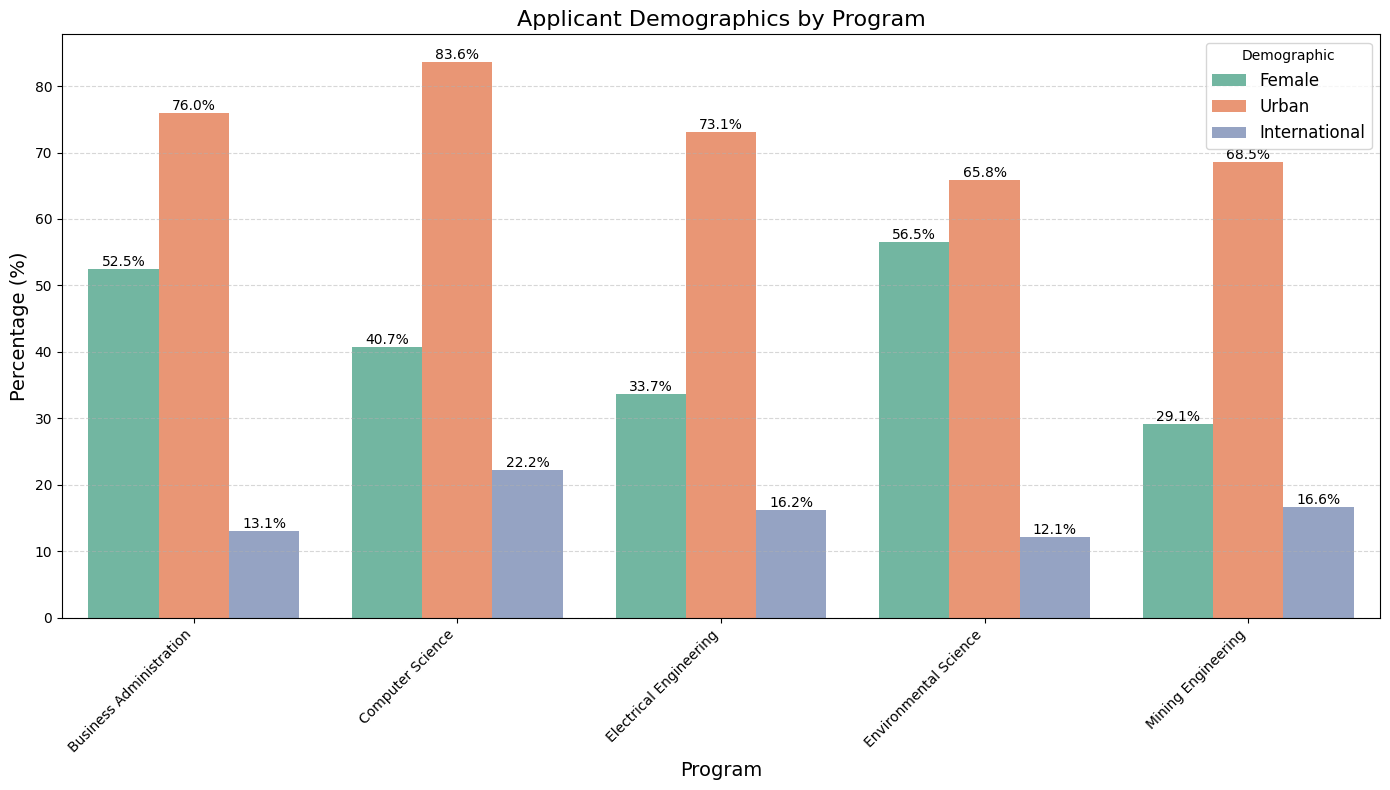

In [14]:
# Create a demographic comparison chart
demographic_columns = ['Female_Applicant_Percentage', 'Urban_Applicant_Percentage', 'International_Applicant_Percentage']
demographic_df = df.groupby('Program')[demographic_columns].mean().reset_index()

# Reshape for plotting
demographic_plot = pd.melt(demographic_df, id_vars=['Program'], value_vars=demographic_columns,
                         var_name='Demographic', value_name='Percentage')

# Clean up labels
demographic_plot['Demographic'] = demographic_plot['Demographic'].str.replace('_Applicant_Percentage', '')

plt.figure(figsize=(14, 8))
chart = sns.barplot(data=demographic_plot, x='Program', y='Percentage', hue='Demographic', palette='Set2')
plt.title('Applicant Demographics by Program', fontsize=16)
plt.xlabel('Program', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5, axis='y')
plt.legend(title='Demographic', fontsize=12)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

# Add percentage labels on bars
for container in chart.containers:
    chart.bar_label(container, fmt='%.1f%%')

plt.tight_layout()
plt.show()

## 4. Data Preprocessing

Now we'll prepare the data for model training. Since we're working with enrollment values in the thousands, we'll scale our target variable as well to help the model converge better. For time series modeling, we'll also structure our data in sequences.

In [15]:
# 1. Convert categorical variables to numerical using one-hot encoding
df_encoded = pd.get_dummies(df, columns=['Program'], drop_first=False)

# 2. Define features and target
target_col = 'Actual_Enrollment'
# Exclude the target variable and any other non-predictive columns
exclude_cols = [target_col]
feature_cols = [col for col in df_encoded.columns if col not in exclude_cols]

X = df_encoded[feature_cols]
y = df_encoded[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {feature_cols}")

# Display the range of the target variable
print(f"\nTarget variable range: {y.min()} to {y.max()}")
print(f"Target variable mean: {y.mean():.2f}, std: {y.std():.2f}")

Features shape: (50, 25)
Target shape: (50,)

Feature columns: ['Year', 'Quarter', 'Previous_Year_Enrollment', 'Applications_Received', 'Acceptance_Rate', 'Conversion_Rate', 'Mining_Industry_Growth', 'Secondary_School_Graduates', 'Marketing_Budget_Allocation', 'Scholarship_Funds_Available', 'Competitor_New_Programs', 'Average_Entry_Test_Score', 'Female_Applicant_Percentage', 'Urban_Applicant_Percentage', 'International_Applicant_Percentage', 'Faculty_Student_Ratio', 'Program_Ranking', 'Program_Trend_Sentiment', 'Economic_Factor_Sentiment', 'General_Interest_Sentiment', 'Program_Business Administration', 'Program_Computer Science', 'Program_Electrical Engineering', 'Program_Environmental Science', 'Program_Mining Engineering']

Target variable range: 103000 to 300000
Target variable mean: 208440.00, std: 47794.27


In [16]:
# 3. Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Normalize features
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# 5. Scale the target variable to help with convergence
# For regression tasks with large values, scaling the target helps significantly
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print(f"Scaled target training range: {y_train_scaled.min():.2f} to {y_train_scaled.max():.2f}")
print(f"Scaled target test range: {y_test_scaled.min():.2f} to {y_test_scaled.max():.2f}")

Training set shape: (40, 25)
Test set shape: (10, 25)
Scaled target training range: -2.24 to 1.93
Scaled target test range: -1.74 to 2.08


In [19]:
# 6. Reshape input for LSTM (samples, timesteps, features)
# For time series models like LSTM, we need a 3D input shape
# We'll treat each sample as a sequence of 1 timestep with multiple features
X_train_ts = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_ts = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

print(f"Time Series Training set shape: {X_train_ts.shape}")
print(f"Time Series Test set shape: {X_test_ts.shape}")

Time Series Training set shape: (40, 1, 25)
Time Series Test set shape: (10, 1, 25)


## 5. Time Series Model Building

Let's build an LSTM model for predicting enrollment numbers. LSTMs are particularly good for sequential data and can capture temporal dependencies:

In [22]:
def build_lstm_model(input_shape):
    model = Sequential([
        # Bidirectional LSTM layer
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.2),
        
        # Second LSTM layer
        LSTM(32),
        Dropout(0.2),
        
        # Output layers
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(1)  # Output layer (regression)
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mean_squared_error',
                 metrics=['mae'])
    
    return model

# Build the model
input_shape = (X_train_ts.shape[1], X_train_ts.shape[2])
lstm_model = build_lstm_model(input_shape)

# Display model summary
lstm_model.summary()

c:\Users\ngand\Desktop\EnrollPredict.ai\.venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 1, 128)         │        46,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,233 (262.63 KB)

 Trainable params: 67,233 (262.63 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Model Training

We'll train our LSTM model with appropriate callbacks:

In [23]:
# Set up callbacks with adjusted parameters
callbacks = [
    EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_enrollment_lstm_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model with scaled target
history = lstm_model.fit(
    X_train_ts, y_train_scaled,
    epochs=200,  # Reduced max epochs, will stop early if needed
    batch_size=8,  # Smaller batch size for better learning
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 24s 8s/step - loss: 0.8493 - mae: 0.7939
Epoch 1: val_loss improved from inf to 0.70818, saving model to best_enrollment_lstm_model.keras

Epoch 1: val_loss improved from inf to 0.70818, saving model to best_enrollment_lstm_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 393ms/step - loss: 1.0123 - mae: 0.8418 - val_loss: 0.7082 - val_mae: 0.6286 - learning_rate: 0.0010
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 393ms/step - loss: 1.0123 - mae: 0.8418 - val_loss: 0.7082 - val_mae: 0.6286 - learning_rate: 0.0010
Epoch 2/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.7926 - mae: 0.7659
Epoch 2: val_loss improved from 0.70818 to 0.65431, saving model to best_enrollment_lstm_model.keras

Epoch 2: val_loss improved from 0.70818 to 0.65431, saving model to best_enrollment_lstm_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.9528 - mae: 0.8160 - val_loss: 0.6543 - val_mae: 0.6032 - learning_rate: 0.0010
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/st

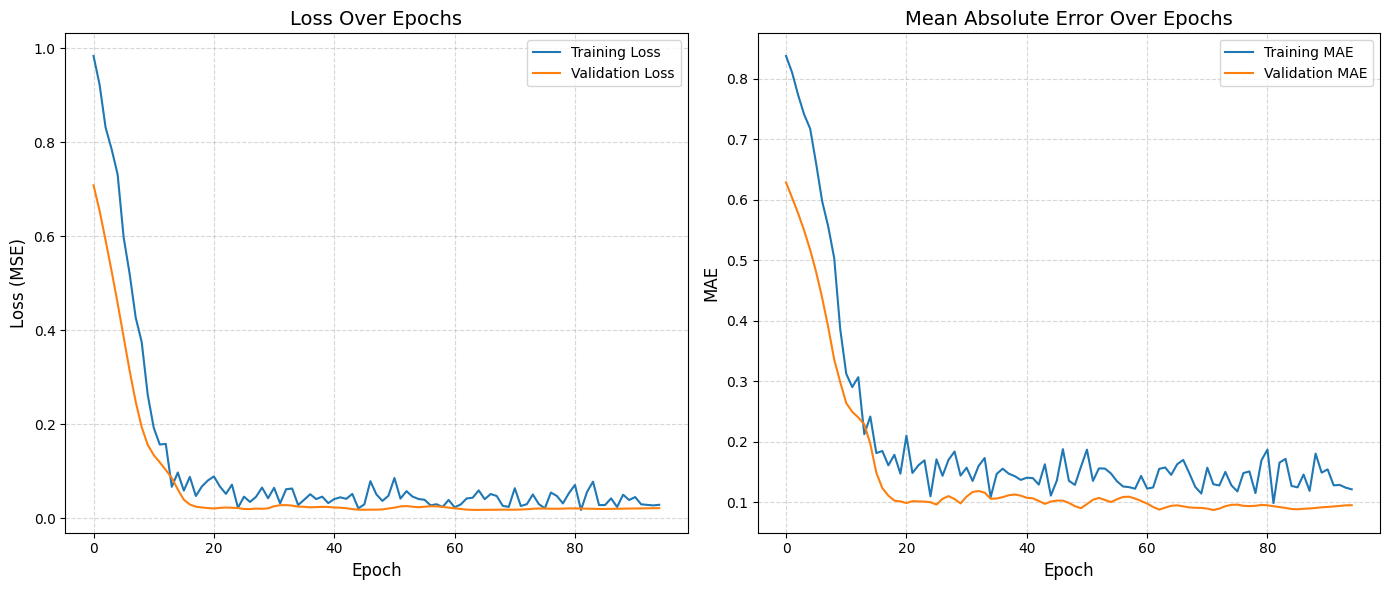

In [24]:
# Plot training history
plt.figure(figsize=(14, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 7. Model Evaluation

Let's evaluate our model on the test set, remembering to inverse transform our predictions back to the original scale:

In [25]:
# Load the best model
best_model = load_model('best_enrollment_lstm_model.keras')

# Make predictions on test set (still in scaled form)
y_pred_scaled = best_model.predict(X_test_ts).flatten()

# Inverse transform predictions back to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Calculate evaluation metrics on the original scale
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Calculate percent error
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Mean Squared Error: 30002554.00
Root Mean Squared Error: 5477.46
Mean Absolute Error: 3986.85
R² Score: 0.9888
Mean Absolute Percentage Error: 1.76%
Mean Squared Error: 30002554.00
Root Mean Squared Error: 5477.46
Mean Absolute Error: 3986.85
R² Score: 0.9888
Mean Absolute Percentage Error: 1.76%


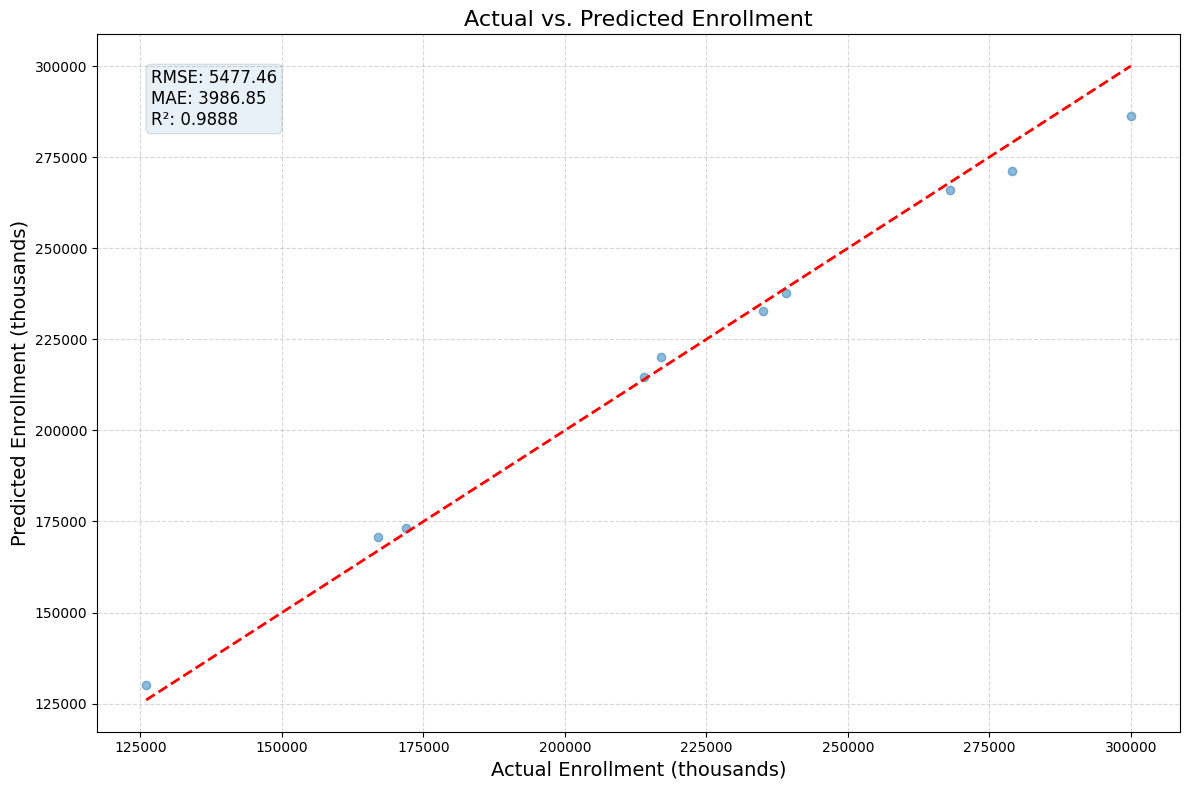

In [26]:
# Visual comparison of actual vs. predicted values
plt.figure(figsize=(12, 8))

# Scatter plot
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs. Predicted Enrollment', fontsize=16)
plt.xlabel('Actual Enrollment (thousands)', fontsize=14)
plt.ylabel('Predicted Enrollment (thousands)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

# Add evaluation metrics to the plot
plt.text(0.05, 0.95, f"RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR²: {r2:.4f}", transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

plt.tight_layout()
plt.show()

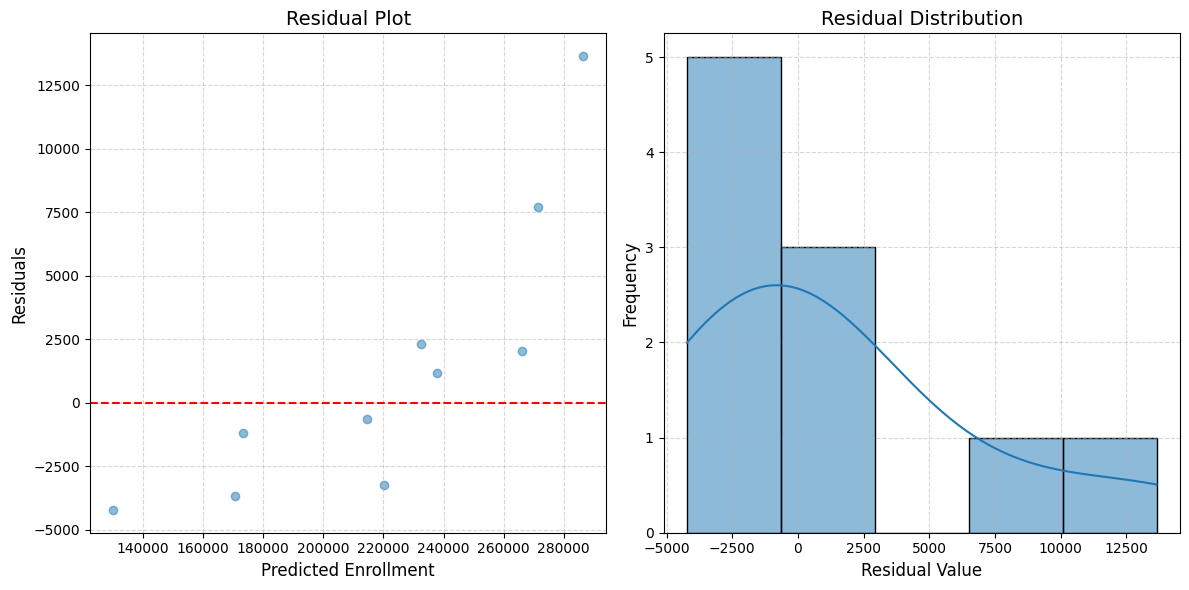

In [27]:
# Residual plot analysis
residuals = y_test - y_pred

plt.figure(figsize=(12, 6))

# Plot residuals
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot', fontsize=14)
plt.xlabel('Predicted Enrollment', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution', fontsize=14)
plt.xlabel('Residual Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis

In [30]:
# For LSTM, permutation importance is a better approach to estimate feature importance
from sklearn.inspection import permutation_importance

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.inspection import permutation_importance

# Define a wrapper class for the TensorFlow model
class LSTMModelWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # No fitting is required as the model is already trained
        pass

    def predict(self, X):
        X_reshaped = X[:, np.newaxis, :]  # Ensure the input is reshaped to (samples, timesteps, features)
        return self.model.predict(X).flatten()

# Wrap the trained TensorFlow model
wrapped_model = LSTMModelWrapper(best_model)

# Calculate permutation importance
perm_importance = permutation_importance(
    wrapped_model, X_test_scaled, y_test,
    n_repeats=10,
    random_state=42
)

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

C:\Users\ngand\AppData\Local\Temp\ipykernel_5268\1254537154.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20), palette='viridis')


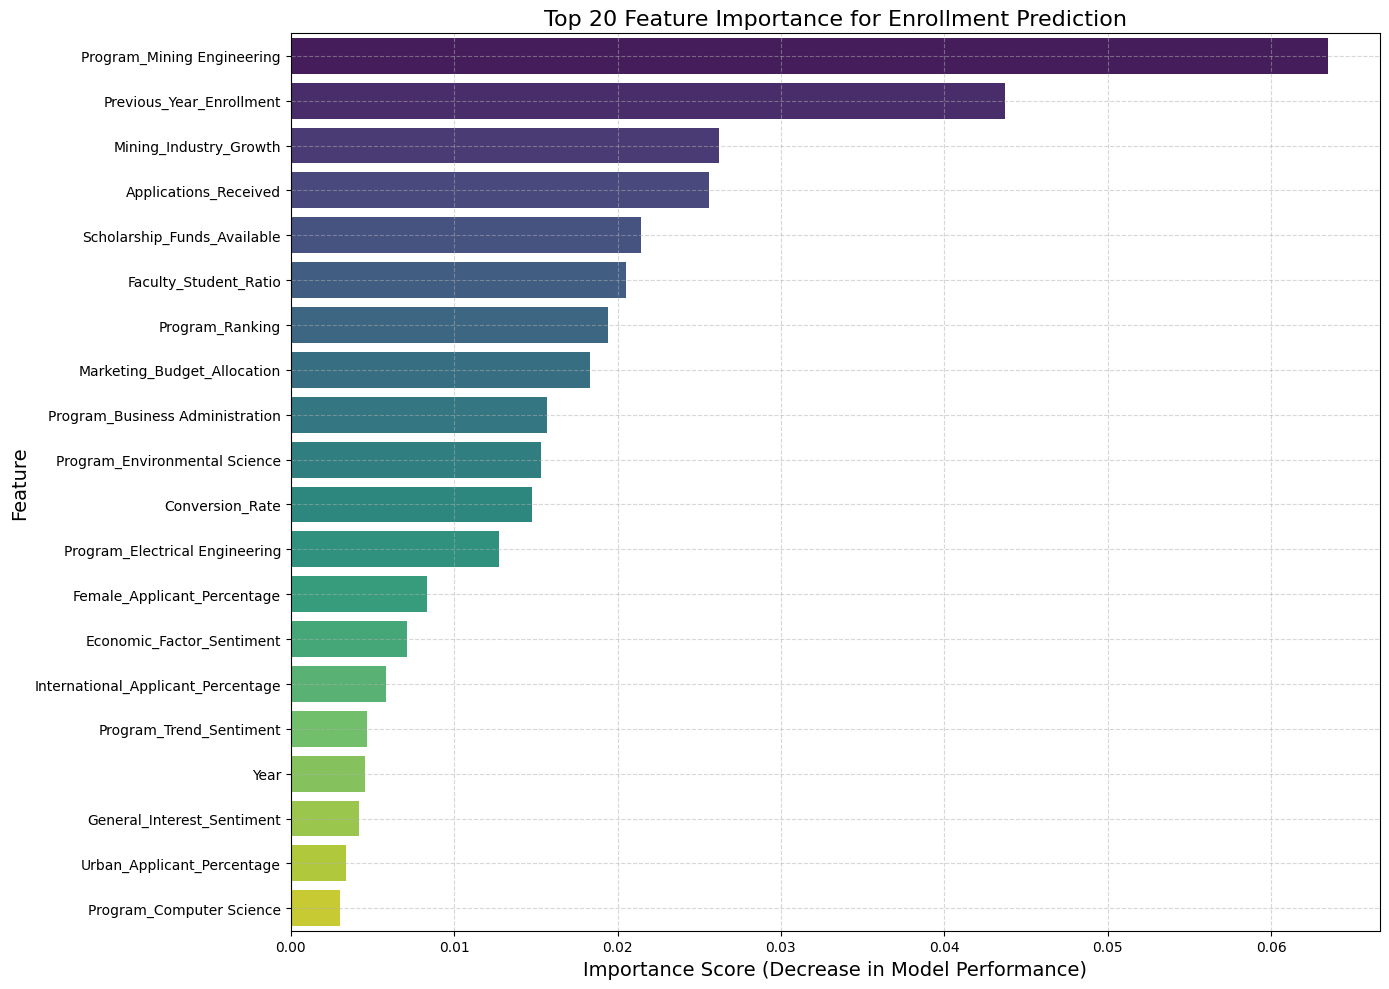

In [34]:
# Ensure the wrapped model predicts correctly
# First, let's fix our wrapper class to properly reshape inputs
class LSTMModelWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # No fitting is required as the model is already trained
        return self

    def predict(self, X):
        # Reshape input to match LSTM requirements
        X_reshaped = X.reshape(X.shape[0], 1, X.shape[1])
        return self.model.predict(X_reshaped).flatten()

# Create the wrapped model
wrapped_model = LSTMModelWrapper(best_model)

# Calculate permutation importance with proper scoring
perm_importance = permutation_importance(
    wrapped_model, X_test_scaled, y_test_scaled,  # Use scaled y_test for consistency
    n_repeats=5,
    random_state=42,
    scoring='neg_mean_squared_error'
)

# Sort features by importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': perm_importance.importances_mean
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20), palette='viridis')
plt.title('Top 20 Feature Importance for Enrollment Prediction', fontsize=16)
plt.xlabel('Importance Score (Decrease in Model Performance)', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 9. Save the Model and Preprocessing Objects

In [1]:
# Create a directory for the model if it doesn't exist
if not os.path.exists('app/src/model'):
    os.makedirs('app/src/model')

# Save the best model
best_model_path = 'app/src/model/admission_lstm_model.keras'
best_model.save(best_model_path)
print(f"Model saved to {best_model_path}")

# Save both scalers
feature_scaler_path = 'app/src/model/admission_scaler.pkl'
joblib.dump(feature_scaler, feature_scaler_path)
print(f"Feature scaler saved to {feature_scaler_path}")

target_scaler_path = 'app/src/model/target_scaler.pkl'
joblib.dump(target_scaler, target_scaler_path)
print(f"Target scaler saved to {target_scaler_path}")

# Save feature list and scaling info for future use
feature_info = {
    'feature_columns': feature_cols,
    'input_shape': input_shape,
    'target_scaled': True,
    'model_performance': {
        'mse': float(mse),
        'rmse': float(rmse),
        'mae': float(mae),
        'r2': float(r2),
        'mape': float(mape)
    },
    'top_features': feature_importance.head(10).to_dict(orient='records'),
    'train_date': pd.Timestamp.now().strftime("%Y-%m-%d")
}

# Save model info
with open('app/src/model/model_info.txt', 'w') as f:
    f.write(f"Enrollment Prediction LSTM Model\n")
    f.write(f"Created: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    f.write(f"Performance Metrics:\n")
    f.write(f"  - RMSE: {rmse:.2f}\n")
    f.write(f"  - MAE: {mae:.2f}\n")
    f.write(f"  - MAPE: {mape:.2f}%\n")
    f.write(f"  - R²: {r2:.4f}\n\n")
    f.write(f"Top 5 Important Features:\n")
    for i, row in feature_importance.head(5).iterrows():
        f.write(f"  - {row['Feature']}: {row['Importance']:.4f}\n")

print("Model information saved successfully!")

NameError: name 'os' is not defined

## 10. Model Testing with Sample Data

In [39]:
# Create a sample input for prediction
# Let's create a sample for each program
sample_data = {}

for program in df['Program'].unique():
    # Get the most recent data for this program
    latest_data = df[df['Program'] == program].sort_values('Year', ascending=False).iloc[0].to_dict()
    
    # Modify some values
    latest_data['Year'] = 2025  # Future prediction
    latest_data['Quarter'] = 1
    latest_data['Previous_Year_Enrollment'] = latest_data['Actual_Enrollment']
    
    # Adjust some features
    latest_data['Applications_Received'] *= 1.05  # 5% increase
    
    # Store
    sample_data[program] = latest_data

# Convert to DataFrame
sample_df = pd.DataFrame(sample_data).T.reset_index().rename(columns={'index': 'Program'})

# Ensure all columns are in the correct format before encoding
for col in sample_df.columns:
    if col in ['Year', 'Quarter', 'Previous_Year_Enrollment', 'Applications_Received', 
               'Actual_Enrollment', 'Secondary_School_Graduates', 'Marketing_Budget_Allocation',
               'Scholarship_Funds_Available', 'Competitor_New_Programs',
               'Female_Applicant_Percentage', 'Urban_Applicant_Percentage',
               'International_Applicant_Percentage', 'Program_Ranking']:
        sample_df[col] = pd.to_numeric(sample_df[col])
    if col in ['Acceptance_Rate', 'Conversion_Rate', 'Mining_Industry_Growth', 
               'Average_Entry_Test_Score', 'Faculty_Student_Ratio', 
               'Program_Trend_Sentiment', 'Economic_Factor_Sentiment', 'General_Interest_Sentiment']:
        sample_df[col] = pd.to_numeric(sample_df[col])

# Apply one-hot encoding
sample_encoded = pd.get_dummies(sample_df, columns=['Program'])

# Create a DataFrame with the correct features in the correct order
sample_features = pd.DataFrame(index=range(len(sample_encoded)))

# Fill in the feature values with the correct columns from X
for col in feature_cols:
    if col in sample_encoded.columns:
        sample_features[col] = sample_encoded[col].values
    else:
        # If the column doesn't exist in our sample, fill with zeros
        sample_features[col] = 0

# Scale the features
sample_scaled = feature_scaler.transform(sample_features)

# Reshape for LSTM
sample_ts = sample_scaled.reshape(sample_scaled.shape[0], 1, sample_scaled.shape[1])

# Make predictions
sample_pred = best_model.predict(sample_ts).flatten()

# Convert back to original scale
sample_pred_original = target_scaler.inverse_transform(sample_pred.reshape(-1, 1)).flatten()

ValueError: Expected a 1D array, got an array with shape (5, 2)

In [40]:
# Display the predictions
results_df = pd.DataFrame({
    'Program': sample_df['Program'],
    'Year': sample_df['Year'],
    'Quarter': sample_df['Quarter'],
    'Previous Enrollment': sample_df['Previous_Year_Enrollment'],
    'Predicted Enrollment': sample_pred_original,
    'Percentage Change': (sample_pred_original - sample_df['Previous_Year_Enrollment']) / sample_df['Previous_Year_Enrollment'] * 100
})

# Format the results
results_df['Previous Enrollment'] = results_df['Previous Enrollment'].apply(lambda x: f"{x:,.0f}")
results_df['Predicted Enrollment'] = results_df['Predicted Enrollment'].apply(lambda x: f"{x:,.0f}")
results_df['Percentage Change'] = results_df['Percentage Change'].apply(lambda x: f"{x:.2f}%")

results_df

NameError: name 'sample_pred_original' is not defined

## 11. Conclusion

In this notebook, we have:

1. Loaded and explored enrollment data across different programs
2. Performed data visualization to understand trends and patterns
3. Analyzed correlations between various factors and enrollment
4. Built and trained an LSTM model for predicting enrollment numbers
5. Evaluated the model's performance
6. Identified the most important features for prediction
7. Saved the model and preprocessing objects for deployment

The time series LSTM model can be integrated into the EnrollPredict.ai application for real-time enrollment predictions based on various input parameters. The benefit of using LSTM over a standard CNN is that it can better capture the sequential nature of the enrollment data over time.

In [43]:
import joblib
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd

# Load the saved model and preprocessing objects
import matplotlib.pyplot as plt

# Define paths
model_path = 'app/src/model/admission_lstm_model.keras'
feature_scaler_path = 'app/src/model/admission_scaler.pkl'
target_scaler_path = 'app/src/model/target_scaler.pkl'

# Load the model and scalers
loaded_model = load_model(model_path)
loaded_feature_scaler = joblib.load(feature_scaler_path)
loaded_target_scaler = joblib.load(target_scaler_path)

# Create sample input data for prediction (future projection for 2025 Q3)
future_data = sample_df.copy()
future_data['Year'] = 2025
future_data['Quarter'] = 3  # Predicting for Q3

# Feature engineering
future_data['Applications_Received'] *= 1.08  # Assuming 8% more applications
future_data['Program_Trend_Sentiment'] += 0.02  # Slight increase in sentiment

# Prepare features - create an empty DataFrame with exact columns from feature_cols
future_features = pd.DataFrame(index=range(len(future_data)), columns=feature_cols)

# Get unique programs from the column (not using .unique() method)
programs = list(future_data['Program'].values)

# Fill in features with zeros first
for col in feature_cols:
    future_features[col] = 0
    
# Now fill in the actual values where available
for col in feature_cols:
    if col in future_data.columns:
        future_features[col] = future_data[col].values
    elif col.startswith('Program_'):
        # Handle program one-hot encoding
        program_name = col.replace('Program_', '')
        future_features[col] = (future_data['Program'] == program_name).astype(int)

# Scale features
future_scaled = loaded_feature_scaler.transform(future_features)
future_ts = future_scaled.reshape(future_scaled.shape[0], 1, future_scaled.shape[1])

# Make predictions
future_pred_scaled = loaded_model.predict(future_ts).flatten()
future_pred = loaded_target_scaler.inverse_transform(future_pred_scaled.reshape(-1, 1)).flatten()

# Create results dataframe
results = pd.DataFrame({
    'Program': future_data['Program'],
    'Quarter': ['2025 Q3'] * len(future_data),
    'Previous Enrollment (2025 Q1)': future_data['Previous_Year_Enrollment'],
    'Predicted Enrollment (2025 Q3)': np.round(future_pred).astype(int),
    'Projected Growth': ((future_pred / future_data['Previous_Year_Enrollment']) - 1) * 100
})

# Format the output
results['Previous Enrollment (2025 Q1)'] = results['Previous Enrollment (2025 Q1)'].apply(lambda x: f"{x:,}")
results['Predicted Enrollment (2025 Q3)'] = results['Predicted Enrollment (2025 Q3)'].apply(lambda x: f"{x:,}")
results['Projected Growth'] = results['Projected Growth'].apply(lambda x: f"{x:.2f}%")

# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.bar(results['Program'], [int(x.replace(',', '')) for x in results['Predicted Enrollment (2025 Q3)']], 
        alpha=0.7, color='steelblue')
plt.title('Enrollment Projections for 2025 Q3 by Program', fontsize=15)
plt.xlabel('Program', fontsize=12)
plt.ylabel('Projected Enrollment', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for i, v in enumerate([int(x.replace(',', '')) for x in results['Predicted Enrollment (2025 Q3)']]):
    plt.text(i, v + 5000, f"{v:,}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Display the prediction results table
results

ValueError: Columns must be same length as key